In [1]:
#==========================================================================
# Import Libraries
#==========================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../Source")
from Posteriors import Posterior

In [5]:
#==========================================================================
# Define: Explicit form of Likelihood, DFD, KSD for Bernoullie Model
#==========================================================================

def neg_loglikel(p, X):
    return ( - X * p.log() + p ).mean()

def dfd(p, X):
    rm = X / p
    rp = (X + 1) / p
    return ( rm ** 2.0 - 2.0 * rp ).mean()

def ksd(p, X):
    rm = X / p
    KX = torch.exp( - torch.cdist(X, X, p=0) ) * ( torch.sigmoid(15 - X) @ torch.sigmoid(15 - X).t() )
    KXm = torch.exp( - torch.cdist(X-1, X, p=0) ) * ( torch.sigmoid(15 - X + 1) @ torch.sigmoid(15 - X).t() )
    return ( (1 - rm) @ (1 - rm).t() * KX ).mean() + 2.0 * ( (1 - rm).flatten() * (KX - KXm).mean(axis=1) ).mean()


Final Loss: -599.74457: 100%|█████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.92it/s]


DFD-Bayes Beta:2.016291856765747


Final Loss: 13.84956: 100%|███████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


KSD-Bayes Beta:5.9350481033325195


Final Loss: -434.71332: 100%|█████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


DFD-Bayes Beta:0.4672875702381134


Final Loss: 12.22620: 100%|███████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]


KSD-Bayes Beta:6.991157054901123


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 285.46it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


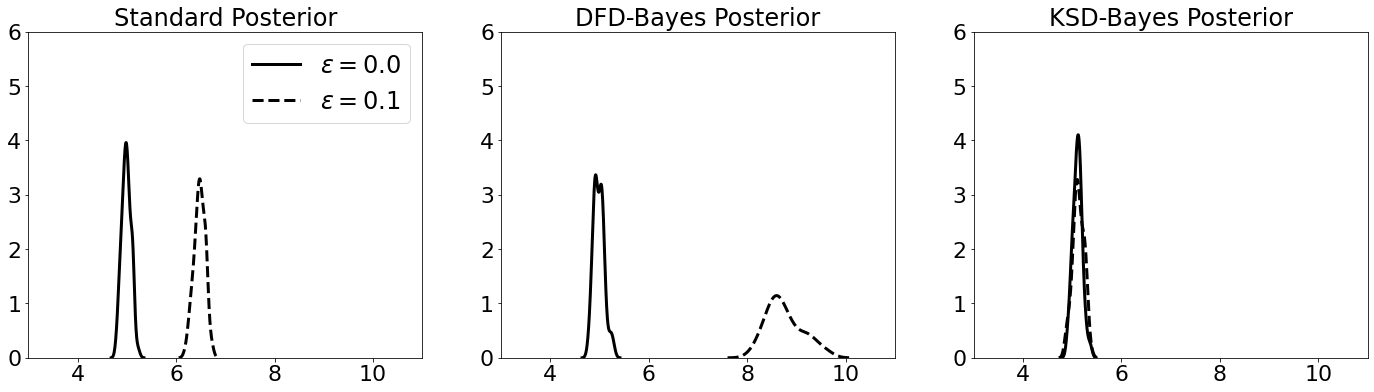

In [8]:
#==========================================================================
# Define: Posterior
#==========================================================================

def experiment(p=5, N=100, xmin=0, xmax=100, outlier_ratio=None, plotaxs=None, linestyle="-", label=""):
    torch.manual_seed(0)
    
    DGP = torch.distributions.Poisson(p)
    X = DGP.sample(sample_shape=(N,1))
    if outlier_ratio != None:
        idx = torch.randint(0, N, (int(N*outlier_ratio),))
        X[idx, :] = 20
    
    prior = torch.distributions.Chi2(torch.tensor([3.0]))
    log_prior = lambda param: prior.log_prob(param).sum()
    transit_p = torch.distributions.Normal(torch.zeros(1), 0.1*torch.ones(1))
    
    nll_bayes = Posterior(log_prior)
    dfd_bayes = Posterior(log_prior)
    ksd_bayes = Posterior(log_prior)
    dfd_loss = lambda param: X.shape[0] * dfd(param, X)
    dfd_loss_X = lambda param, X: X.shape[0] * dfd(param, X)
    ksd_loss = lambda param: X.shape[0] * ksd(param, X)
    ksd_loss_X = lambda param, X: X.shape[0] * ksd(param, X)
    
    nll_bayes.loss = lambda param: X.shape[0] * neg_loglikel(param, X)
    nll_sample = nll_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20)

    p_init, _ = dfd_bayes.minimise(dfd_loss, prior.sample(), ite=1000, lr=0.01, progress=False)
    boot_minimisers, _ = dfd_bayes.bootstrap_minimisers(X, 100, lambda: p_init, loss_func=dfd_loss_X, ite=100, lr=0.01)
    beta_opt = dfd_bayes.optimal_beta(dfd_loss, boot_minimisers)
    print("DFD-Bayes Beta:" + str(float(beta_opt)))
    dfd_bayes.loss = dfd_loss
    dfd_sample = dfd_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20, beta=beta_opt)

    p_init, _ = ksd_bayes.minimise(ksd_loss, prior.sample(), ite=1000, lr=0.01, progress=False)
    boot_minimisers, _ = ksd_bayes.bootstrap_minimisers(X, 100, lambda: p_init, loss_func=ksd_loss_X, ite=100, lr=0.01)
    beta_opt = ksd_bayes.optimal_beta(ksd_loss, boot_minimisers)
    print("KSD-Bayes Beta:" + str(float(beta_opt)))
    ksd_bayes.loss = ksd_loss
    ksd_sample = ksd_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20, beta=beta_opt)
    
    sns.kdeplot(nll_sample.flatten(), linewidth=3.0, color="black", linestyle=linestyle, label=label, ax=plotaxs[0])
    sns.kdeplot(dfd_sample.flatten(), linewidth=3.0, color="black", linestyle=linestyle, label=label, ax=plotaxs[1])
    sns.kdeplot(ksd_sample.flatten(), linewidth=3.0, color="black", linestyle=linestyle, label=label, ax=plotaxs[2])
    
    plotaxs[0].set_xlim(xmin, xmax)
    plotaxs[1].set_xlim(xmin, xmax)
    plotaxs[2].set_xlim(xmin, xmax)

fig, axs = plt.subplots(1, 3, figsize=(24,6))
experiment(p=5, N=500, xmin=3, xmax=11, plotaxs=axs, linestyle="-", label=r"$\epsilon = 0.0$")
experiment(p=5, N=500, xmin=3, xmax=11, outlier_ratio=0.1, plotaxs=axs, linestyle="--", label=r"$\epsilon = 0.1$")
for j in range(3):
    axs[j].set_ylim(0, 6)
    axs[j].set_ylabel("")
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)
axs[0].legend(loc="upper right", fontsize=24)
axs[0].set_title("Standard Posterior", fontsize=24)
axs[1].set_title("DFD-Bayes Posterior", fontsize=24)
axs[2].set_title("KSD-Bayes Posterior", fontsize=24)
fig.savefig('figure_16.eps', format='eps')